### Simple Baseline Detection In Manuscripts

In this notebook we are going to see how to detect baselines for manuscripts.

The method we are going to cover is relatively simple, and most of what we use are not novel. They are just combination of bits and pieces from here and there. 

We import packages as the following

In [1]:
# packages
import numpy as np # used for numerical analysis
import pandas as pd # used for more timeseries analysis has some handy functions 
import cv2 # python bindings of the comprehensive computer vision package opencv
import matplotlib.pyplot as plt # for visualizing our results in the notebook
import glob # for obtaining paths of the images in our dataset
# Show image
fig_size = plt.rcParams["figure.figsize"] 
# Set figure width to 12 and height to 9
fig_size[0] = 21
fig_size[1] = 18
plt.rcParams["figure.figsize"] = fig_size

Let's load the images in a list

In [2]:
# Reading the images from the path
image_folder = "./images/"
images_paths = glob.glob(image_folder+"*.jpeg") # creates a list of paths from the folder
images = [cv2.imread(path) for path in images_paths] # loads the images in the path as ndarray



Here is a simple function to visualize a list of images

In [3]:
def show_images(images, 
               cols = 1, 
               titles = None,
               cmap="gray",
               title_color="yellow"):
    """Display a list of images in a single figure with matplotlib.
    
    code slightly modified from:
    https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: 
        titles = ['Image {}'.format(str(i))  for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        a.imshow(image, cmap=cmap)
        a.set_title(title, color=title_color)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

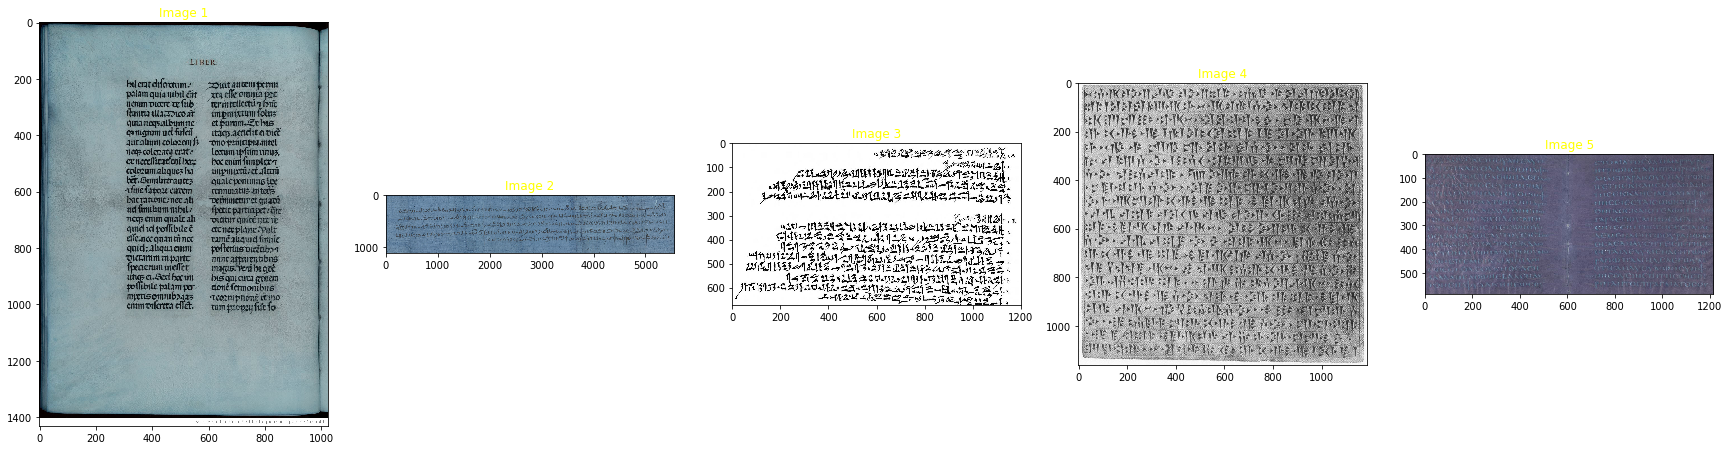

In [4]:
# Show original images
show_images(images)

### Preprocessing Images

In most cases the images need preprocessing before any attempts of baseline calculations are made. Most common preprocessing methods, are binarization, gradient computation, background - foreground extraction etc.

We won't cover those in detail. 

In [5]:
def getCannyEdges(img,
                  ksize=4, 
                  th1=100, 
                  th2=200, 
                  k2size=2,
                 hue=False):
    "Detect edges of the image with opencv canny edge detector"
    if hue is False:
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        hue_im = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        huechannel = hue_im[:,:,0]
        gray_image = huechannel

    # Canny detector with dilate
    kernel_size = ksize
    kernel = np.ones((kernel_size, kernel_size))
    kernel = kernel / kernel.sum()
    fil_image = cv2.filter2D(gray_image, # src grayscale image 
                             -1, # output image size -1 == same as input
                            kernel # filter kernel
                            )
    edges = cv2.Canny(fil_image,
                      th1, # hysteria threshold1
                      th2, # hysteria threshold2
                     )
    morph_kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, 
                                             ksize=(k2size,k2size))

    edges_dil = cv2.morphologyEx(edges, 
                                 cv2.MORPH_DILATE,
                                 kernel=morph_kernel)
    #
    return edges_dil

    

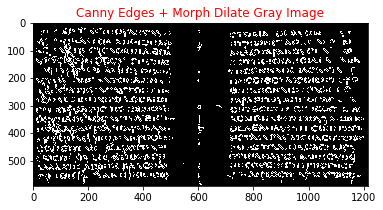

In [6]:
# Working with single image
img = images[4]

edges = getCannyEdges(img, th1=30, th2=70, 
                      hue=False)
plt.title("Canny Edges + Morph Dilate Gray Image", color='red')

plt.imshow(edges, cmap='gray')

Don't forget! 

This is baseline detection, so yes the image is still noisy, but it looks good enough for rough estimation of lines 

Still let's check for other color spaces as well

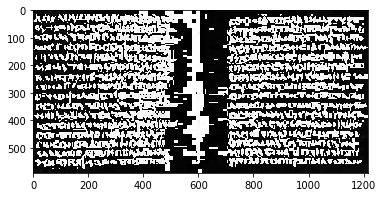

In [7]:
# convert the color space from RGB to HSV
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue = hsv_image[:,:,0]
invhue = cv2.bitwise_not(hue)

plt.imshow(invhue, cmap='gray')

Both are average good:

- the canny edge version has less noisy output but requires more tinkering with parameters, 

- hsv transformation works almost out of the box, with a raw result that is not so good.

We'll use the canny edge version, but don't forget to keep the hsv transformation around when you are working with this kind of problem.

(1216,)
(1215,)


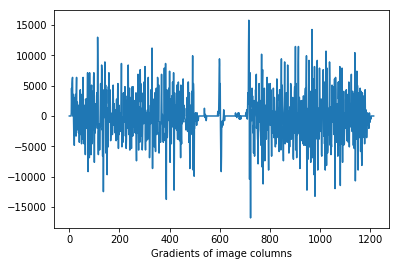

In [8]:
# Detect columns
# simple obtaining lines in an image 
imcolsum = edges.sum(axis=0, 
                     dtype=np.int32)
print(imcolsum.shape)

mincoledges = np.ediff1d(imcolsum)
plt.xlabel("Gradients of image columns")
plt.plot(mincoledges)
print(mincoledges.shape)

Our columns are separated with the lower difference areas right in the middle of the plot

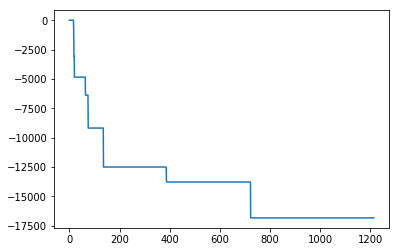

In [9]:
colserie = pd.Series(mincoledges)
colmax = colserie.cummax()
colmin = colserie.cummin()
coldiff = colmax - colmin
plt.plot(colmin)

Let's transform our edges to a serie, and detect the cummulative minimum of the serie.

This should give us a rough idea of the beginning and the end of the columns, why ?

Because our columns have the minimum edge

723


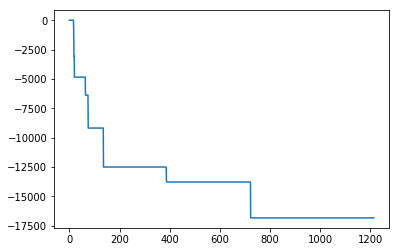

In [10]:
# Front pass
cummincolserie = colserie.cummin()
mincol_start = cummincolserie.idxmin()
plt.plot(cummincolserie)
print(mincol_start)

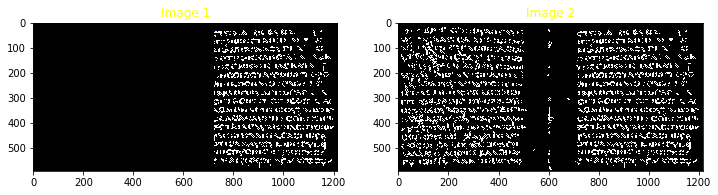

In [12]:
# let's mask the column area to see it better in the image
imcopy = edges.copy()

imcopy[:, :mincol_start] = 0

show_images([imcopy, edges])

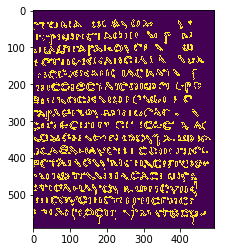

In [13]:
# Let's clip our image to single column
imghalf = imcopy[:, mincol_start:]

plt.imshow(imghalf)

(591,)
(590,)


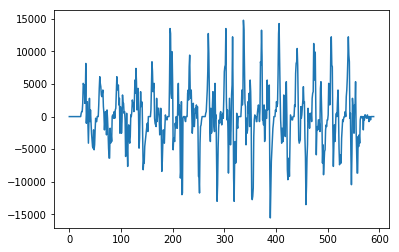

In [27]:
imrowsum = imghalf.sum(axis=1, dtype=np.int32)
print(imrowsum.shape)

minrowedges = np.ediff1d(imrowsum)
plt.plot(minrowedges)
print(minrowedges.shape)

(590,)


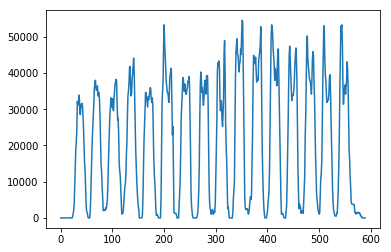

In [28]:
cumserie = pd.Series(minrowedges)
newserie = cumserie.cumsum()
print(newserie.shape)

plt.plot(newserie)

In [29]:
def peakdet(vector: np.ndarray, 
            delta):
    """
    slightly modified from:
    https://gist.github.com/endolith/250860

    Converted from MATLAB script at http://billauer.co.il/peakdet.html    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    #
    if not np.isscalar(delta):
        raise ValueError('Input argument delta must be a scalar')
    if delta <= 0:
        raise ValueError('Input argument delta must be positive')
    mn = float("inf")
    mx = float("-inf")
    mnpos, mxpos = np.nan, np.nan
    rownb = vector.shape[0] # take the row number
    row_indices = np.arange(rownb) # buffer array holding row indices
    lookformax = True # max/min switch
    for i in np.arange(rownb):
        current_point = vector[i]
        if current_point > mx:
            mx = current_point
            mxpos = row_indices[i]
        if current_point < mn:
            mn = current_point
            mnpos = row_indices[i]
        
        if lookformax:
            if current_point < mx-delta:
                maxtab.append((mxpos, mx))
                mn = current_point
                mnpos = row_indices[i]
                lookformax = False
        else:
            if current_point > mn+delta:
                mx = current_point
                mxpos = row_indices[i]
                lookformax = True

    return np.array(maxtab)

16 (16, 2)
(590,)
(16, 2)
(591, 493)
[[   35 33915]
 [   67 37995]
 [  107 38250]
 [  141 44115]
 [  173 35955]
 [  200 53295]
 [  248 39015]
 [  271 40290]
 [  317 48960]
 [  351 54570]
 [  387 52785]
 [  408 53295]
 [  443 47430]
 [  477 50235]
 [  509 53040]
 [  544 53295]]


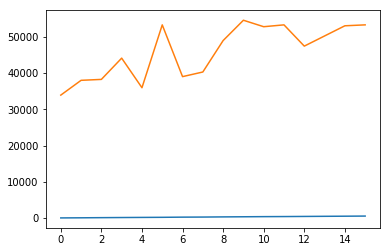

In [32]:
meanval = newserie.mean()
seriemax = peakdet(vector=newserie, delta=meanval)
print(len(seriemax), seriemax.shape)
plt.plot(seriemax)
print(newserie.shape)
print(seriemax.shape)
print(imghalf.shape)
print(seriemax)

493


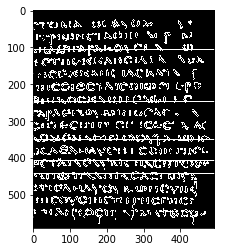

In [83]:
# Let's draw those lines
start_col = 0
end_col = imghalf.shape[1]
print(end_row)
newcopy = imghalf.copy()
ecopy = edges.copy()

for ypos, val in seriemax:
    point1=(start_col, ypos)
    point2=(end_col, ypos)
    cv2.line(newcopy,
            point1,point2,
            (255,255,0))
    
plt.imshow(newcopy, cmap="gray")

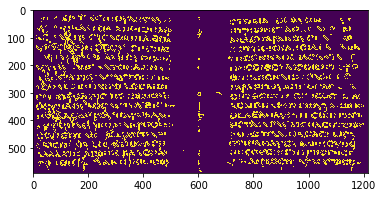

In [76]:
plt.imshow(ecopy)